
# Classification with the German Traffic Sign Recognition Benchmark

<img src="img/sv_pp_TrafficSignRecognition.jpg" align="right" width=200>
An automatic road sign recognition system first locates road signs within images captured by an imaging sensor on-board of a vehicle, and then identifies road signs assisting the driver to properly operate the vehicle.

Automated road sign recognition is a difficult task. There are a number of important issues that need to be taken into consideration. These include: illumination conditions, direction of sign's face, status of paint on signs, placement of multiple signs near each other, torn and tilted signs, variations in sign's scale, obstacles such as tree, image sensor's properties, car vibrations, etc. 

Assuming that the road sign has been previously located in the image, neural networks may be employed to implement the classification module because they have proven to be good classifiers and have been able to successfully solve several object recognition problems. 

In this notebook you will work on a classification task of several road signs with neural networks. The images will be obtained from [a large, lifelike database of traffic sign images: the German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news).

In [1]:
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Load data and preprocessing

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge, with the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

The training set archive is structured as follows:

* One directory per class
* Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images
* Training images are grouped by tracks
* Each track contains 30 images of one single physical traffic sign

You will work with a small sub-set of this benchmark, by selecting only **one track of each of the following 4 classes**:

<table>
<tr>
<td><img src="img/00004_00022.png"></td>
<td><img src="img/00012_00026.png"></td>
<td><img src="img/00010_00016.png"></td>
<td><img src="img/00003_00009.png"></td>
</tr>
<tr>
<td>00003</td>
<td>00007</td>
<td>00013</td>
<td>00014</td>
</tr>
</table>

The images can be downloaded from [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads).

The images are PPM images (RGB color). Files are numbered in two parts:

    XXXXX_YYYYY.ppm

The first part, `XXXXX`, represents the track number. The second part, `YYYYY`, is a running number within the track.

The annotations are stored in CSV format (field separator is ";" (semicolon) ). The annotations contain meta information about the image and the class:

* Filename - Image file the following information applies to
* Width, Height - Dimensions of the image
* Roi.x1,Roi.y1, Roi.x2,Roi.y2 - Location of the sign within the image (Images contain a border around the actual sign of 10 percent of the sign size, at least 5 pixel)
* ClassId - The class of the traffic sign

The following cell will read tracks 5, 40, 24, and 8 from classes 3, 7, 13, and 14 respectively. The data will be stored in the resulting variables.

In [2]:
from packages.gtrsb import readTrafficSigns

classes = [3, 7, 13, 14]
tracks = {3: 5, 7: 40, 13: 24, 14: 8}
trainImages, trainDims, trainROIs, trainLabels, filenames = readTrafficSigns('./data', classes, tracks)

In [3]:
print(len(trainImages))
print(trainDims[0])
print(trainROIs[0])
print(trainLabels[0])

120
(30, 29)
((6, 5), (25, 24))
3


### Image processing

Please notice the following information about images:

* The images contain one traffic sign each
* Images contain a border of 10 % around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches
* Image sizes vary between 15x15 to 250x250 pixels
* Images are not necessarily squared
* The actual traffic sign is not necessarily centered within the image.This is true for images that were close to the image border in the full camera image

<img src="img/GT-Example.png" align="right" width=100>
The ROI is defined as:
* `ROI.x1`: X-coordinate of top-left corner of traffic sign bounding box
* `ROI.y1`: Y-coordinate of top-left corner of traffic sign bounding box
* `ROI.x2`: X-coordinate of bottom-right corner of traffic sign bounding box
* `ROI.y2`: Y-coordinate of bottom-right corner of traffic sign bounding box

The pixels of the image will be the inputs of the neural network. But the number of inputs is constant, thus you need to make all the images in the dataset to be the same resolution.

Moreover, the number of inputs has a significant input on the cost of training. A compromise is needed, by keeping the resolution low while still making possible the distinction of road signs.

As a suggestion, you could try with image sizes between 10x10 and 20x20 pixels.

In addition, the original images are stored in RGB format, that is, each images has three pixel planes (one for each component). As a recommendation, you might use only the red channel (i.e. a single plane) which seems to contain the most interesting information about the road sign.

In summary, the recommended image processing steps are:

* Crop the image, i.e. select only the part of the image inside the ROI
* Scale the image to a fixed, small resultion
* Select the red channel
* Adjust the contrast with histogram equalization
* Finally, normalize the pixel values to the interval [-1,+1]

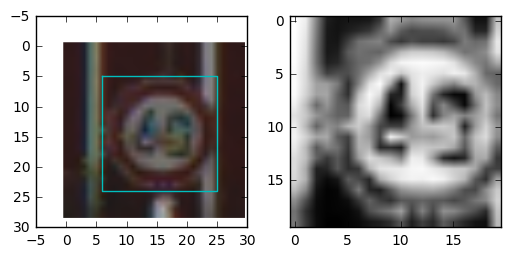

In [4]:
from packages.gtrsb import processImage, plotTrafficSign

i = 0
roi = trainROIs[i]
p1, p2 = roi
x1, y1 = p1
x2, y2 = p2
plt.subplot(121)
plt.imshow(trainImages[i])
plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],'c')
plt.subplot(122)
pr_img = processImage(trainImages[i],trainROIs[i])
plt.imshow(pr_img, cmap='gray');

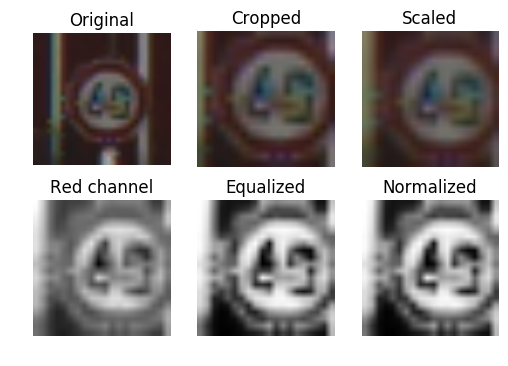

In [5]:
i = 0
img = trainImages[i]
roi = trainROIs[i]
plotTrafficSign(img, roi)

In [6]:
import numpy as np
X = np.empty(shape=(0,400))
y = []
class_labels=map(str,classes)
for i in range(120):
    eq_img = processImage(trainImages[i],trainROIs[i])
    inpt = eq_img.reshape(1,400)
    target = class_labels.index(trainLabels[i])
    X = np.vstack((X,inpt))
    y.append(target)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

## Build the model and train

In [8]:
net = MLPClassifier(solver='sgd',\
                    hidden_layer_sizes=(50, ),\
                    max_iter=4000)

In [9]:
net.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=4000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Analysis of the network

### Classification report

In [10]:
expected = y_test
predicted = net.predict(X_test)
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      0.86      0.92        14
          1       0.87      1.00      0.93        13
          2       1.00      1.00      1.00        13
          3       1.00      1.00      1.00         8

avg / total       0.96      0.96      0.96        48



### Confusion matrix

In [11]:
print(metrics.confusion_matrix(expected, predicted))

[[12  2  0  0]
 [ 0 13  0  0]
 [ 0  0 13  0]
 [ 0  0  0  8]]


### Loss curve

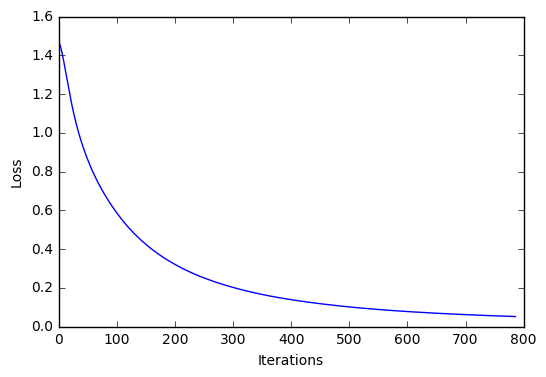

In [12]:
plt.plot(net.loss_curve_);
plt.xlabel('Iterations');
plt.ylabel('Loss');